# Analisi sui dati "Boston Housing"

## Introduzione ai dati
Il dataset "Boston Housing" del 1970 è un dataset classico nel campo dell'apprendimento automatico e dell'econometria.\
È stato introdotto per la prima volta nel 1978 da Harrison e Rubinfeld nel loro articolo "Hedonic Prices and the Demand for Clean Air" (Prezzi hedonici e domanda per l'aria pulita).  

Il dataset contiene informazioni su 506 abitazioni della Boston Standard Metropolitan Statistical Area, Massachusetts, negli Stati Uniti.\
È stato creato per esaminare la relazione tra il valore mediano delle abitazioni e una serie di variabili descrittive, tra cui:

1. `crim`: tasso di criminalità per persona in un quartiere.
2. `zn`: proporzione di terreno residenziale assegnato per lotti di oltre 25.000 piedi quadrati (circa 2323 metri quadrati).
3. `indus`: proporzione di ettari dedicati alle attività commerciali non al dettaglio per città.
4. `chas`: variabile binaria che indica se la proprietà si affaccia sul fiume Charles (1 se è vero, 0 altrimenti).
5. `nox`: concentrazione di ossidi di azoto (parti per 10 milioni).
6. `rm`: numero medio di stanze per abitazione.
7. `age`: proporzione di unità occupate dal proprietario costruite prima del 1940.
8. `dis`: distanze ponderate dai cinque centri di impiego di Boston.
9. `rad`: indice di accessibilità alle strade principali.
10. `tax`: tasso di imposta sulla proprietà a valore pieno per 10.000 dollari.
11. `ptratio`: rapporto studenti-insegnanti per quartiere.
12. `lstat`: percentuale di persone a basso reddito.

La variabile che prenderemo come risposta in questa applicazione è il valore mediano delle abitazioni (`medv`), espresso in migliaia di dollari.\
Questo valore rappresenta il valore medio (mediano) delle case occupate dai proprietari nello specifico distretto censuario.\

## Analisi Esplorativa

In [ ]:
# importazione delle librarie necessarie
from AutoLib import *
# parametri grafici per aumentare la risoluzione di stampa
# de- commentare se si vogliono ottenere i grafici proposti nell'analisi
#plt.rcParams['figure.dpi'] = 300
#sns.set(rc={'figure.dpi': 300})

In [ ]:
# lettura dei dati da csv
dati = read_data("Boston.csv",
                 verbose = True)

La funzione ci segnala l'assenza di valori mancanti nel dataset e che tutte le variabili sono di tipo numerico.

In [ ]:
# analisi esplorativa dei dati
auto_eda(dati,
         'medv',
         print_corr=False,
         plot_density=True,
         cor_plot=True,
         threshold=0.5,
         pair_plot=True)

## Adattamento di un modello di regressione ad albero

In [ ]:
# Selezione della variabilerisposta
y = dati['medv']
# Creazione matrice del modello
X = model_matrix(dati,
                 'medv',
                 intercept=False,
                 dummies=False,
                 verbose = True)

In [ ]:
# definizione di un oggetto della classe AutoTree come albero di regressione
reg = AutoTree('regressione')
# diagnostica sull'albero inizializzato
print(reg)

In [ ]:
# Divisione del dataset in insieme di stima ed insieme di verifica
X_train, X_test, y_train, y_test = split_data(X, y,
                                              size = 0.25)

In [ ]:
# Primo adattamento del modello ai dati
reg.auto_fit(X_train,y_train,
             verbose = 2,
             plot=True)

In [ ]:
# Valori stimati dal modello
previsioni = reg.predict(X_test)
# Valutazione delle performance del modello
perf(y_test, 
     previsioni,
     plot=False)

## Pruning

In [ ]:
# Potatura automatica dell'albero di regressione
auto_pruned = reg.auto_prune(X_train, y_train,
                             auto=True,
                             plot=False,
                             n_splits=10,
                             print_path=False)
print(auto_pruned)

In [ ]:
# Adattamento dell'albero con valore di alpha selezionato in modo automatico
auto_pruned.auto_fit(X_train, y_train, verbose=1, plot=False)
# valori previsti
previsioni2 = auto_pruned.predict(X_test)
# valutazione della performance del modello potato automaticamente
perf(y_test, previsioni2)

In [ ]:
# Potatura "manuale"
manually_pruned = reg.auto_prune(X_train, y_train,
                                 auto=False)

In [ ]:
# Adattamento dell'albero potato manualmente
manually_pruned.auto_fit(X_train, y_train, 
                         verbose=1, 
                         plot=True)
# Previsione e valutazione delle performance
previsioni3 = manually_pruned.predict(X_test)
perf(y_test,previsioni3,
     plot=True,
     metodo="Albero di regressione (potato)")

## Ensemble

### Bagging

In [ ]:
# inizializziamo l'ensemble con bagging
bag = AutoEnsemble(method = 'rf', n_estimators = 100, random_state = 0) # usiamo 'bagging' ma in realta il default e' 'rf'
# fit dei dati
bag.auto_fit(X_train, y_train)
# predizione + performance
bag_pred = bag.predict(X_test)

perf(y_test, bag_pred)

In [ ]:
# tuning dei parametri : B non è un parametro fondamentale, basta scegliere un valore che non sia troppo piccolo
parametri = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [3, 5,10,15,20],
        'min_samples_split': [1,2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

bag2 = bag.auto_tuning(
    X_train,
    y_train,
    parametri,
    n_splits=5,
    n_iter=10,
    randomized=True
)

# performance modello ottimizzato
bag_pred2 = bag2.predict(X_test)
perf(y_test, bag_pred2,metodo='Bagging',plot=True)

#### Feature Selection

In [ ]:
# feature selection del modello bagging
bag2.auto_features(X_train,
                   threshold='median',
                   plot=True)

### Random Forest

In [ ]:
# inizializzazione con RF con i predittori selezionati 
rf = AutoEnsemble(max_features=6) # m=6
# adattamento ai dati di training
rf.auto_fit(X_train, y_train)
# predict + performance
rf_pred = rf.predict(X_test)
perf(y_test, rf_pred)

In [ ]:
# tuning 
parametri_rf = {'n_estimators': [200,500,1000],
                'criterion':['squared_error','friedman_mse'],
                'max_features': [None,6,'sqrt','log2']}

rf2 = rf.auto_tuning(X_train,y_train,
                     parametri_rf,
                     n_splits=5,
                     n_iter=10,
                     random_state=0)

In [ ]:
# Performance del modello ottimizzato
rf_pred2 = rf2.predict(X_test)
perf(y_test, rf_pred2,metodo='Random Forest',plot=True)

In [ ]:
# Importanza dei predittori (Random Forest)
rf2.auto_features(X_train)

### Boosting

In [ ]:
# Inizializzazione
boost = AutoEnsemble('gb')
# adattamento
boost.auto_fit(X_train, y_train)
# previsione
y_pred = boost.predict(X_test)
# performance
perf(y_test, y_pred)


In [ ]:
# tuning
parametri ={
    'max_depth': [1,2,3],
    'n_estimators': [500, 1000, 5000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1,0.2],
    'criterion': ['friedman_mse', 'squared_error']
}

boost2 = boost.auto_tuning(X_train, y_train, 
                           parametri,
                           n_splits=5, 
                           n_iter=10,
                           random_state=0)

pred2 = boost2.predict(X_test)
perf(y_test,pred2,plot=True,metodo='Boosting')

## Confronto fra metodi

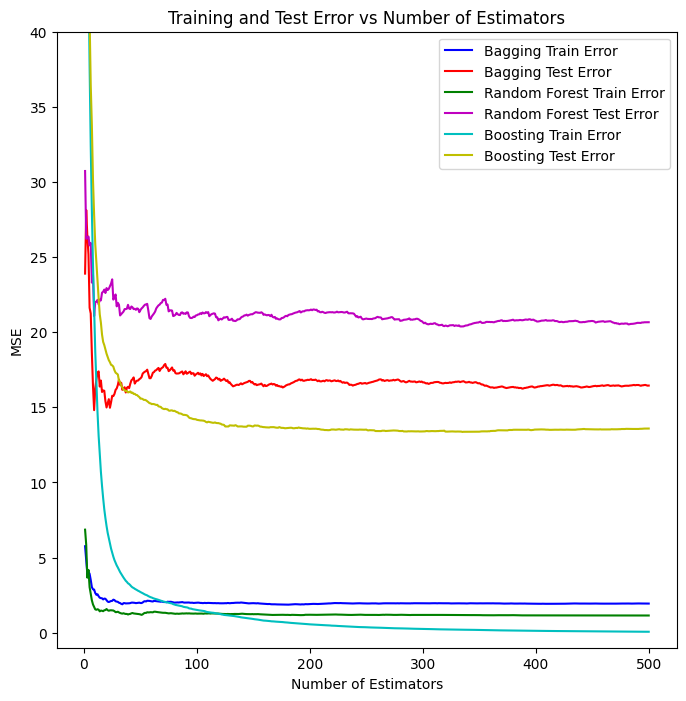

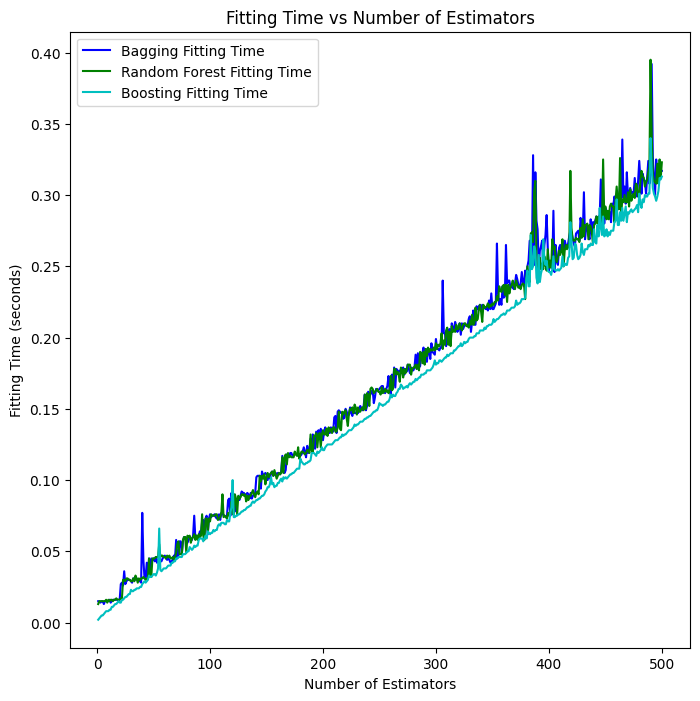

Tempo impegato per il confronto:  5 minuti circa


In [23]:
# confronto tra i metodi 
method_comparison(X_train,
                  X_test,
                  y_train,
                  y_test,{'bagging':bag2,"rf":rf2,"boosting":boost2},
                  train=True,
                  max_estimators=500)